# ML MB model with custom loss function for predicting MB on monthly resolution

Based on tests performed in notebook test_custom_loss.ipynb

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import xgboost as xgb
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results
from sklearn.model_selection import KFold
from itertools import product
from sklearn.model_selection import GroupKFold
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from plotting_functions import plot_prediction_per_fold
from matplotlib import pyplot as plt

### 0.1 Helper functions

In [2]:
# Functions for data processing

# Reshape dataframe to monthly resolution
def reshape_dataset_monthly(df, id_vars, variables, months_order): 

    df_list = []

    for var in variables:
        # Filter columns for the current variable and the ID columns
        cols = [col for col in df.columns if col.startswith(var) or col in id_vars]
        df_var = df[cols]

        # Rename the columns to have just the month
        df_var = df_var.rename(columns=lambda x: x.split('_')[-1] if x not in id_vars else x)

        # Melt the DataFrame to long format and add month order
        df_melted = pd.melt(df_var, id_vars=id_vars, var_name='month', value_name=var)
        df_melted['month'] = pd.Categorical(df_melted['month'], categories=months_order, ordered=True)

        df_list.append(df_melted)

    # Combine all reshaped DataFrames
    df_final = df_list[0]
    for df_temp in df_list[1:]:
        df_final = pd.merge(df_final, df_temp, on=id_vars + ['month'], how='left')

    # Sort the DataFrame based on ID variables and month
    df_final = df_final.sort_values(by=id_vars + ['month'])

    return(df_final)

### 0.2 Plotting functions

In [51]:
def plot_prediction_subplot(y1, y2, data_type:str, ax, n_toplot=10**10, fold=False):
    """
    Plot model predictions y1 vs. actual observations y2 and show
    calculated error metrics.

    Parameters:
    y1 : np.array
        Predicted labels.
    y2 : np.array
        Actual labels.
    data_type : str
        Type of data, e.g. "Validation" or "Test".
    ax : array
        Axis object
    n_toplot : int
        Number of points to plot. 
    """
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error

    if fold:
        figsize=(5,5)
        fontsize=12
        s= 15
    else:
        figsize=(8,8)
        fontsize=16
        s= 20
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)

    y_max = 8#7 #max(max(y1), max(y2))[0] + 1
    y_min = -15#1 #min(min(y1), min(y2))[0] - 1
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    #fig = plt.figure(figsize=figsize)
    sc = ax.scatter(y_plt, ann_plt, c=z, s=s)
    sc.set_clim(0,0.2)
    #plt.tick_params(labelsize=14)
    plt.colorbar(sc,ax=ax,fraction=0.046) 
    lineStart = y_min
    lineEnd = y_max
    ax.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    ax.set_title("Model Evaluation " + data_type, fontsize=fontsize)
    ax.set_ylabel('Modeled SMB (m.w.e)', fontsize=fontsize)
    ax.set_xlabel('Reference SMB (m.w.e)', fontsize=fontsize)
    ax.axvline(0.0, ls='-.', c='k')
    ax.axhline(0.0, ls='-.', c='k')
    ax.set_xlim(lineStart, lineEnd)
    ax.set_ylim(lineStart, lineEnd)
    ax.set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=False), ),
    r'$MSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=True), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    return ax
    #plt.show()

## 1 Prepare training and test data

In [3]:
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_annual = data[data['balance_netto'].notna()]
glacier_data_annual.reset_index(drop=True, inplace=True)

glacier_data_winter = data[data['balance_winter'].notna()]
glacier_data_winter.reset_index(drop=True, inplace=True)

glacier_data_summer = data[data['balance_summer'].notna()]
glacier_data_summer.reset_index(drop=True, inplace=True)

C:\Users\kasj\AppData\Local\Temp\ipykernel_10680\398696404.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [4]:
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]

# Get test dataset for each of annual, winter and summer mass balance
df_test_annual = glacier_data_annual[glacier_data_annual['BREID'].isin(test_glaciers)]
df_test_winter = glacier_data_winter[glacier_data_winter['BREID'].isin(test_glaciers)]
df_test_summer = glacier_data_summer[glacier_data_summer['BREID'].isin(test_glaciers)]
# 54 has 189 points
# 703 has 30 points
# 941 has 70 points
# 1280 has 71 points
# 2320 has 83 points
# 2478 has 89 points
# 2769 has 121 points
# 3133 has 38 points
# 3137 has 65 points
# 3138 has 6 points
# 3141 has 72 points

# Get training dataset for each of annual, winter and summer mass balance
df_train_annual = glacier_data_annual[~glacier_data_annual['BREID'].isin(test_glaciers)]
df_train_winter = glacier_data_winter[~glacier_data_winter['BREID'].isin(test_glaciers)]
df_train_summer = glacier_data_summer[~glacier_data_summer['BREID'].isin(test_glaciers)]

# Add number of months to each dataframe
df_train_annual['n_months']=12
df_train_winter['n_months']=7
df_train_summer['n_months']=5
df_test_annual['n_months']=12
df_test_winter['n_months']=7
df_test_summer['n_months']=5

print(f'Train/test annual: {len(df_train_annual)}/{len(df_test_annual)}')
print(f'Train/test winter: {len(df_train_winter)}/{len(df_test_winter)}')
print(f'Train/test summer: {len(df_train_summer)}/{len(df_test_summer)}')
print(f'All train/test: {len(df_train_annual)+len(df_train_winter)+len(df_train_summer)} / {len(df_test_annual)+len(df_test_winter)+len(df_test_summer)}')
print(f'Fraction train/test: {(len(df_train_annual)+len(df_train_winter)+len(df_train_summer)) / (len(df_test_annual)+len(df_test_winter)+len(df_test_summer)+len(df_train_annual)+len(df_train_winter)+len(df_train_summer))} / {(len(df_test_annual)+len(df_test_winter)+len(df_test_summer)) /(len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer))}')
print(f'Total entries: {len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer)}')


Train/test annual: 2845/1065
Train/test winter: 2752/1000
Train/test summer: 2901/1028
All train/test: 8498 / 3093
Fraction train/test: 0.7331550340781641 / 0.26684496592183593
Total entries: 11591


C:\Users\kasj\AppData\Local\Temp\ipykernel_10680\1542360467.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_annual['n_months']=12
C:\Users\kasj\AppData\Local\Temp\ipykernel_10680\1542360467.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_winter['n_months']=7
C:\Users\kasj\AppData\Local\Temp\ipykernel_10680\1542360467.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

### 1.1 Prepare training data

In [5]:
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border', 'lat','lon', 'slope_factor']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
sol_rad_net = ['ssr_oct','ssr_nov','ssr_dec','ssr_jan','ssr_feb','ssr_mar','ssr_apr','ssr_may','ssr_jun','ssr_jul','ssr_aug','ssr_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']
#sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
u_wind = ['u10_oct','u10_nov','u10_dec','u10_jan','u10_feb','u10_mar','u10_apr','u10_may','u10_jun','u10_jul','u10_aug','u10_sep']
v_wind = ['v10_oct','v10_nov','v10_dec','v10_jan','v10_feb','v10_mar','v10_apr','v10_may','v10_jun','v10_jul','v10_aug','v10_sep']
#f_albedo = ['fal_oct','fal_nov','fal_dec','fal_jan','fal_feb','fal_mar','fal_apr','fal_may','fal_jun','fal_jul','fal_aug','fal_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
                         dewpt_temp, surface_pressure, sol_rad_net, sol_therm_down, u_wind, v_wind] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# df_train_X_... now contains columns of all chosen features and column with annual, winter or summer balance

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']

for name in var:
    for mon in mon_summer:
        if mon not in mon_winter:
            df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        if mon not in mon_summer:
            df_train_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
#df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])

# Use altitude_diff instead of altitude and altitude_climate
df_train_summer_clean['altitude_diff'] = df_train_summer_clean['altitude_climate']-df_train_summer_clean['altitude']
df_train_summer_clean = df_train_summer_clean.drop(['altitude','altitude_climate'], axis=1)
df_train_winter_clean['altitude_diff'] = df_train_winter_clean['altitude_climate']-df_train_winter_clean['altitude']
df_train_winter_clean = df_train_winter_clean.drop(['altitude','altitude_climate'], axis=1)
df_train_annual_clean['altitude_diff'] = df_train_annual_clean['altitude_climate']-df_train_annual_clean['altitude']
df_train_annual_clean = df_train_annual_clean.drop(['altitude','altitude_climate'], axis=1)

df_train_summer_clean = df_train_summer_clean.dropna(axis=1, how='all')
df_train_winter_clean = df_train_winter_clean.dropna(axis=1, how='all')
df_train_annual_clean = df_train_annual_clean.dropna(axis=1, how='all')

n_summer = len(df_train_summer_clean)
n_winter = len(df_train_winter_clean)
n_annual = len(df_train_annual_clean)

df_train_summer_clean.insert(0, 'id', list(range(n_summer)))
df_train_winter_clean.insert(0, 'id', list(range(n_summer, n_summer+n_winter)))
df_train_annual_clean.insert(0, 'id', list(range(n_summer+n_winter, n_summer+n_winter+n_annual)))

# Columns that are not monthly climate variables (identifiers and static variables)
#id_vars = ['id','BREID', 'year', 'altitude','balance','aspect','slope','altitude_climate','n_months']
id_vars = ['id','BREID', 'year', 'altitude_diff','balance','aspect','slope','n_months']

# Extract the unique variable names and month names from the column names
#variables = set(col.split('_')[0] for col in df.columns if col not in id_vars)
#months = set(col.split('_')[-1] for col in df.columns if col not in id_vars)
variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
summer_months_order = ['may', 'jun', 'jul', 'aug', 'sep']
winter_months_order = ['oct','nov','dec','jan','feb','mar','apr']
annual_months_order = ['oct','nov','dec','jan','feb','mar','apr', 'may', 'jun', 'jul', 'aug', 'sep']

# Reshape dataframes to monthly resolution
df_train_summer_final = reshape_dataset_monthly(df_train_summer_clean, id_vars, variables, summer_months_order)
df_train_winter_final = reshape_dataset_monthly(df_train_winter_clean, id_vars, variables, winter_months_order)
df_train_annual_final = reshape_dataset_monthly(df_train_annual_clean, id_vars, variables, annual_months_order)

# Combine training data in one dataframe
df_train_summer_final.reset_index(drop=True, inplace=True)
df_train_winter_final.reset_index(drop=True, inplace=True)
df_train_annual_final.reset_index(drop=True, inplace=True)

data_list = [df_train_summer_final, df_train_winter_final, df_train_annual_final]
df_train_final = pd.concat(data_list)
df_train_final

,id,BREID,year,altitude_diff,balance,aspect,slope,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,596,1963,11.181943,-3.41,2.509464,0.238202,5,may,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702
1,0,596,1963,11.181943,-3.41,2.509464,0.238202,5,jun,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953
2,0,596,1963,11.181943,-3.41,2.509464,0.238202,5,jul,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025
3,0,596,1963,11.181943,-3.41,2.509464,0.238202,5,aug,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591
4,0,596,1963,11.181943,-3.41,2.509464,0.238202,5,sep,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34135,8497,3129,1967,-592.166788,1.58,2.526225,0.068208,12,may,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
34136,8497,3129,1967,-592.166788,1.58,2.526225,0.068208,12,jun,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480
34137,8497,3129,1967,-592.166788,1.58,2.526225,0.068208,12,jul,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605
34138,8497,3129,1967,-592.166788,1.58,2.526225,0.068208,12,aug,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


### 1.2 Prepare test data

In [6]:
# Prepare test

# Select features for training
df_test_annual_clean = df_test_annual.drop(drop_cols, axis=1)
df_test_winter_clean = df_test_winter.drop(drop_cols, axis=1)
df_test_summer_clean = df_test_summer.drop(drop_cols, axis=1)
df_test_annual_clean = df_test_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_test_winter_clean = df_test_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_test_summer_clean = df_test_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_test_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_test_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_test_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
#var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
#mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
#mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        if mon not in mon_winter:
            df_test_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        if mon not in mon_summer:
            df_test_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
#df_test_all = pd.concat([df_test_annual_clean, df_test_summer_clean, df_test_winter_clean])
#df_test_all.reset_index(drop=True, inplace=True)

# Use altitude_diff instead of altitude and altitude_climate
df_test_summer_clean['altitude_diff'] = df_test_summer_clean['altitude_climate']-df_test_summer_clean['altitude']
df_test_summer_clean = df_test_summer_clean.drop(['altitude','altitude_climate'], axis=1)
df_test_winter_clean['altitude_diff'] = df_test_winter_clean['altitude_climate']-df_test_winter_clean['altitude']
df_test_winter_clean = df_test_winter_clean.drop(['altitude','altitude_climate'], axis=1)
df_test_annual_clean['altitude_diff'] = df_test_annual_clean['altitude_climate']-df_test_annual_clean['altitude']
df_test_annual_clean = df_test_annual_clean.drop(['altitude','altitude_climate'], axis=1)

df_test_summer_clean = df_test_summer_clean.dropna(axis=1, how='all')
df_test_winter_clean = df_test_winter_clean.dropna(axis=1, how='all')
df_test_annual_clean = df_test_annual_clean.dropna(axis=1, how='all')

n_summer = len(df_test_summer_clean)
n_winter = len(df_test_winter_clean)
n_annual = len(df_test_annual_clean)

df_test_summer_clean.insert(0, 'id', list(range(n_summer)))
df_test_winter_clean.insert(0, 'id', list(range(n_summer, n_summer+n_winter)))
df_test_annual_clean.insert(0, 'id', list(range(n_summer+n_winter, n_summer+n_winter+n_annual)))

# Columns that are not monthly climate variables (identifiers and static variables)
#id_vars = ['id','BREID', 'year', 'altitude','balance','aspect','slope','altitude_climate','n_months']

# Extract the unique variable names and month names from the column names
#variables = set(col.split('_')[0] for col in df.columns if col not in id_vars)
#months = set(col.split('_')[-1] for col in df.columns if col not in id_vars)
#variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
#summer_months_order = ['may', 'jun', 'jul', 'aug', 'sep']
#winter_months_order = ['oct','nov','dec','jan','feb','mar','apr']
#annual_months_order = ['oct','nov','dec','jan','feb','mar','apr', 'may', 'jun', 'jul', 'aug', 'sep']

# Reshape datasets to monthly resolution
df_test_summer_final = reshape_dataset_monthly(df_test_summer_clean, id_vars, variables, summer_months_order)
df_test_winter_final = reshape_dataset_monthly(df_test_winter_clean, id_vars, variables, winter_months_order)
df_test_annual_final = reshape_dataset_monthly(df_test_annual_clean, id_vars, variables, annual_months_order)

# Combine training data in one dataframe
df_test_summer_final.reset_index(drop=True, inplace=True)
df_test_winter_final.reset_index(drop=True, inplace=True)
df_test_annual_final.reset_index(drop=True, inplace=True)

data_list = [df_test_summer_final, df_test_winter_final, df_test_annual_final]
df_test_final = pd.concat(data_list)
df_test_final

,id,BREID,year,altitude_diff,balance,aspect,slope,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,54,2013,-129.772081,-6.24,0.629597,0.278773,5,may,277.677979,4.286715e+05,-237874.5,20979516.0,0.580414,-3367191.50,0.001159
1,0,54,2013,-129.772081,-6.24,0.629597,0.278773,5,jun,283.339630,-2.133166e+06,-4024573.5,17728592.0,0.198752,-3994740.00,0.003054
2,0,54,2013,-129.772081,-6.24,0.629597,0.278773,5,jul,283.829285,-2.731458e+06,-5184939.5,15538729.0,0.131911,-4661453.00,0.003977
3,0,54,2013,-129.772081,-6.24,0.629597,0.278773,5,aug,283.778412,-1.295387e+06,-3545874.5,10510849.0,0.130799,-4018348.50,0.004691
4,0,54,2013,-129.772081,-6.24,0.629597,0.278773,5,sep,280.982513,9.352438e+03,-1756179.5,6908671.0,0.130148,-4441106.50,0.001449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12775,3092,3141,2017,-160.580241,-3.29,2.906044,0.131717,12,may,277.690887,-5.189375e+02,-71670.0,17926120.0,0.530146,-2093793.25,0.003567
12776,3092,3141,2017,-160.580241,-3.29,2.906044,0.131717,12,jun,280.319031,1.046328e+05,-101796.5,13385372.0,0.480811,162197.00,0.008162
12777,3092,3141,2017,-160.580241,-3.29,2.906044,0.131717,12,jul,282.416504,-2.174798e+06,-4535185.5,15446657.0,0.183955,-3726261.25,0.007537
12778,3092,3141,2017,-160.580241,-3.29,2.906044,0.131717,12,aug,281.939026,-1.997971e+06,-3884410.5,11212546.0,0.135438,-3417520.00,0.007390


## 2 Split training data for cross validation

In [7]:
# Select features for training
df_train_X_reduce = df_train_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_train_X = df_train_X_reduce[[c for c in df_train_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for training
df_train_y = df_train_final[['balance']]

# Get arrays of features+metadata and targets
X_train, y_train = df_train_X.values, df_train_y.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_final['id'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train, y_train, gp_s))

#print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
#print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
#print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
#print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
#print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
#print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
#print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
#print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
#print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
#print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))
print(len(gp_s))
print(y_train.shape)
print(X_train.shape)
print(df_train_X.columns)
print(df_train_y.columns)

67909
(67909, 1)
(67909, 13)
Index(['altitude_diff', 'aspect', 'slope', 't2m', 'sshf', 'slhf', 'ssrd',
       'fal', 'str', 'tp', 'id', 'n_months', 'month'],
      dtype='object')
Index(['balance'], dtype='object')


In [8]:
# Check fold indices for training/validation data
fold_indices = []

for train_index, val_index in group_kf.split(X_train, y_train, gp_s):
    print("TRAIN:", train_index, "VALIDATION:", val_index)
    print("shape(train):", train_index.shape, "test:", val_index.shape)
    fold_indices.append((train_index, val_index))


TRAIN: [    0     1     2 ... 67894 67895 67896] VALIDATION: [   15    16    17 ... 67906 67907 67908]
shape(train): (54329,) test: (13580,)
TRAIN: [    0     1     2 ... 67906 67907 67908] VALIDATION: [   10    11    12 ... 67858 67859 67860]
shape(train): (54329,) test: (13580,)
TRAIN: [    0     1     2 ... 67906 67907 67908] VALIDATION: [    5     6     7 ... 67846 67847 67848]
shape(train): (54326,) test: (13583,)
TRAIN: [    0     1     2 ... 67906 67907 67908] VALIDATION: [   25    26    27 ... 67834 67835 67836]
shape(train): (54326,) test: (13583,)
TRAIN: [    5     6     7 ... 67906 67907 67908] VALIDATION: [    0     1     2 ... 67894 67895 67896]
shape(train): (54326,) test: (13583,)


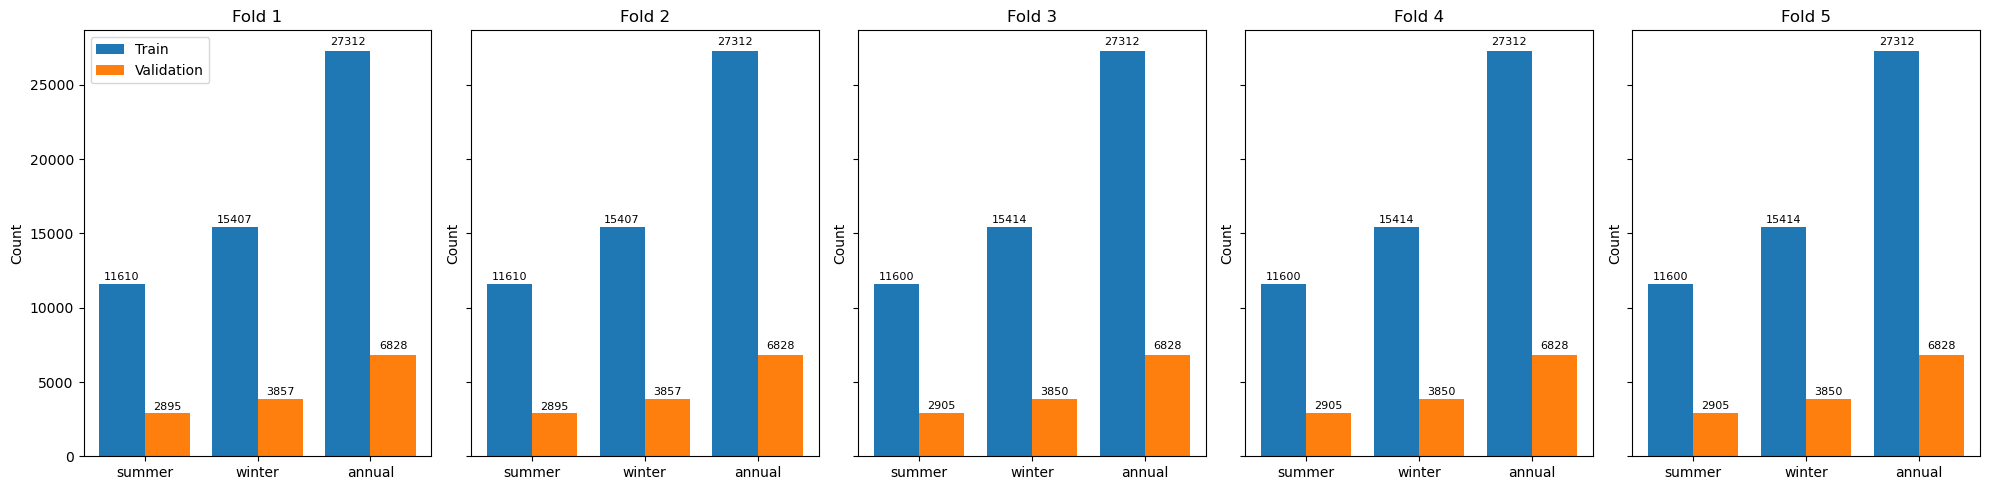

In [10]:
# Count number of annual and seasonal per fold

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

# Create a color map or list for the bars
colors = ['C0', 'C1']

n_months_to_season = {5: 'summer', 7: 'winter', 12: 'annual'}

for i, (train_index, val_index) in enumerate(splits_s):
    ax = axes[i]

    n_months_train = df_train_X.iloc[train_index]['n_months']
    n_months_val = df_train_X.iloc[val_index]['n_months']
    
    # Counts
    n_months_train_counts = dict(zip(*np.unique(n_months_train, return_counts=True)))
    n_months_val_counts = dict(zip(*np.unique(n_months_val, return_counts=True)))
    
    #n_months_values = sorted(set(n_months_train_counts.keys()).union(n_months_val_counts.keys()))
    n_months_values = sorted(set(n_months_train_counts.keys()).union(n_months_val_counts.keys()))
    season_names = [n_months_to_season[n_months] for n_months in n_months_values]

    train_positions = np.arange(len(n_months_values))
    val_positions = train_positions + 0.4 
    
    train_counts = [n_months_train_counts.get(x, 0) for x in n_months_values]
    ax.bar(train_positions, train_counts, width=0.4, label='Train', color=colors[0])
    
    val_counts = [n_months_val_counts.get(x, 0) for x in n_months_values]
    ax.bar(val_positions, val_counts, width=0.4, label='Validation', color=colors[1])

    # Annotate each bar with the respective count
    for j in range(len(n_months_values)):
        train_count = n_months_train_counts.get(n_months_values[j], 0)
        val_count = n_months_val_counts.get(n_months_values[j], 0)
        train_pos = train_positions[j]
        val_pos = val_positions[j]
        
        ax.text(train_pos, train_count + max(train_count, val_count) * 0.01, str(train_count),
                ha='center', va='bottom', fontsize=8, color='k')

        ax.text(val_pos, val_count + max(train_count, val_count) * 0.01, str(val_count),
                ha='center', va='bottom', fontsize=8, color='k')
    
    ax.set_title(f'Fold {i+1}')
    #ax.set_xlabel('n_months')
    ax.set_ylabel('Count')
    ax.set_xticks(train_positions + 0.2) 
    #ax.set_xticklabels(n_months_values)  
    ax.set_xticklabels(season_names)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

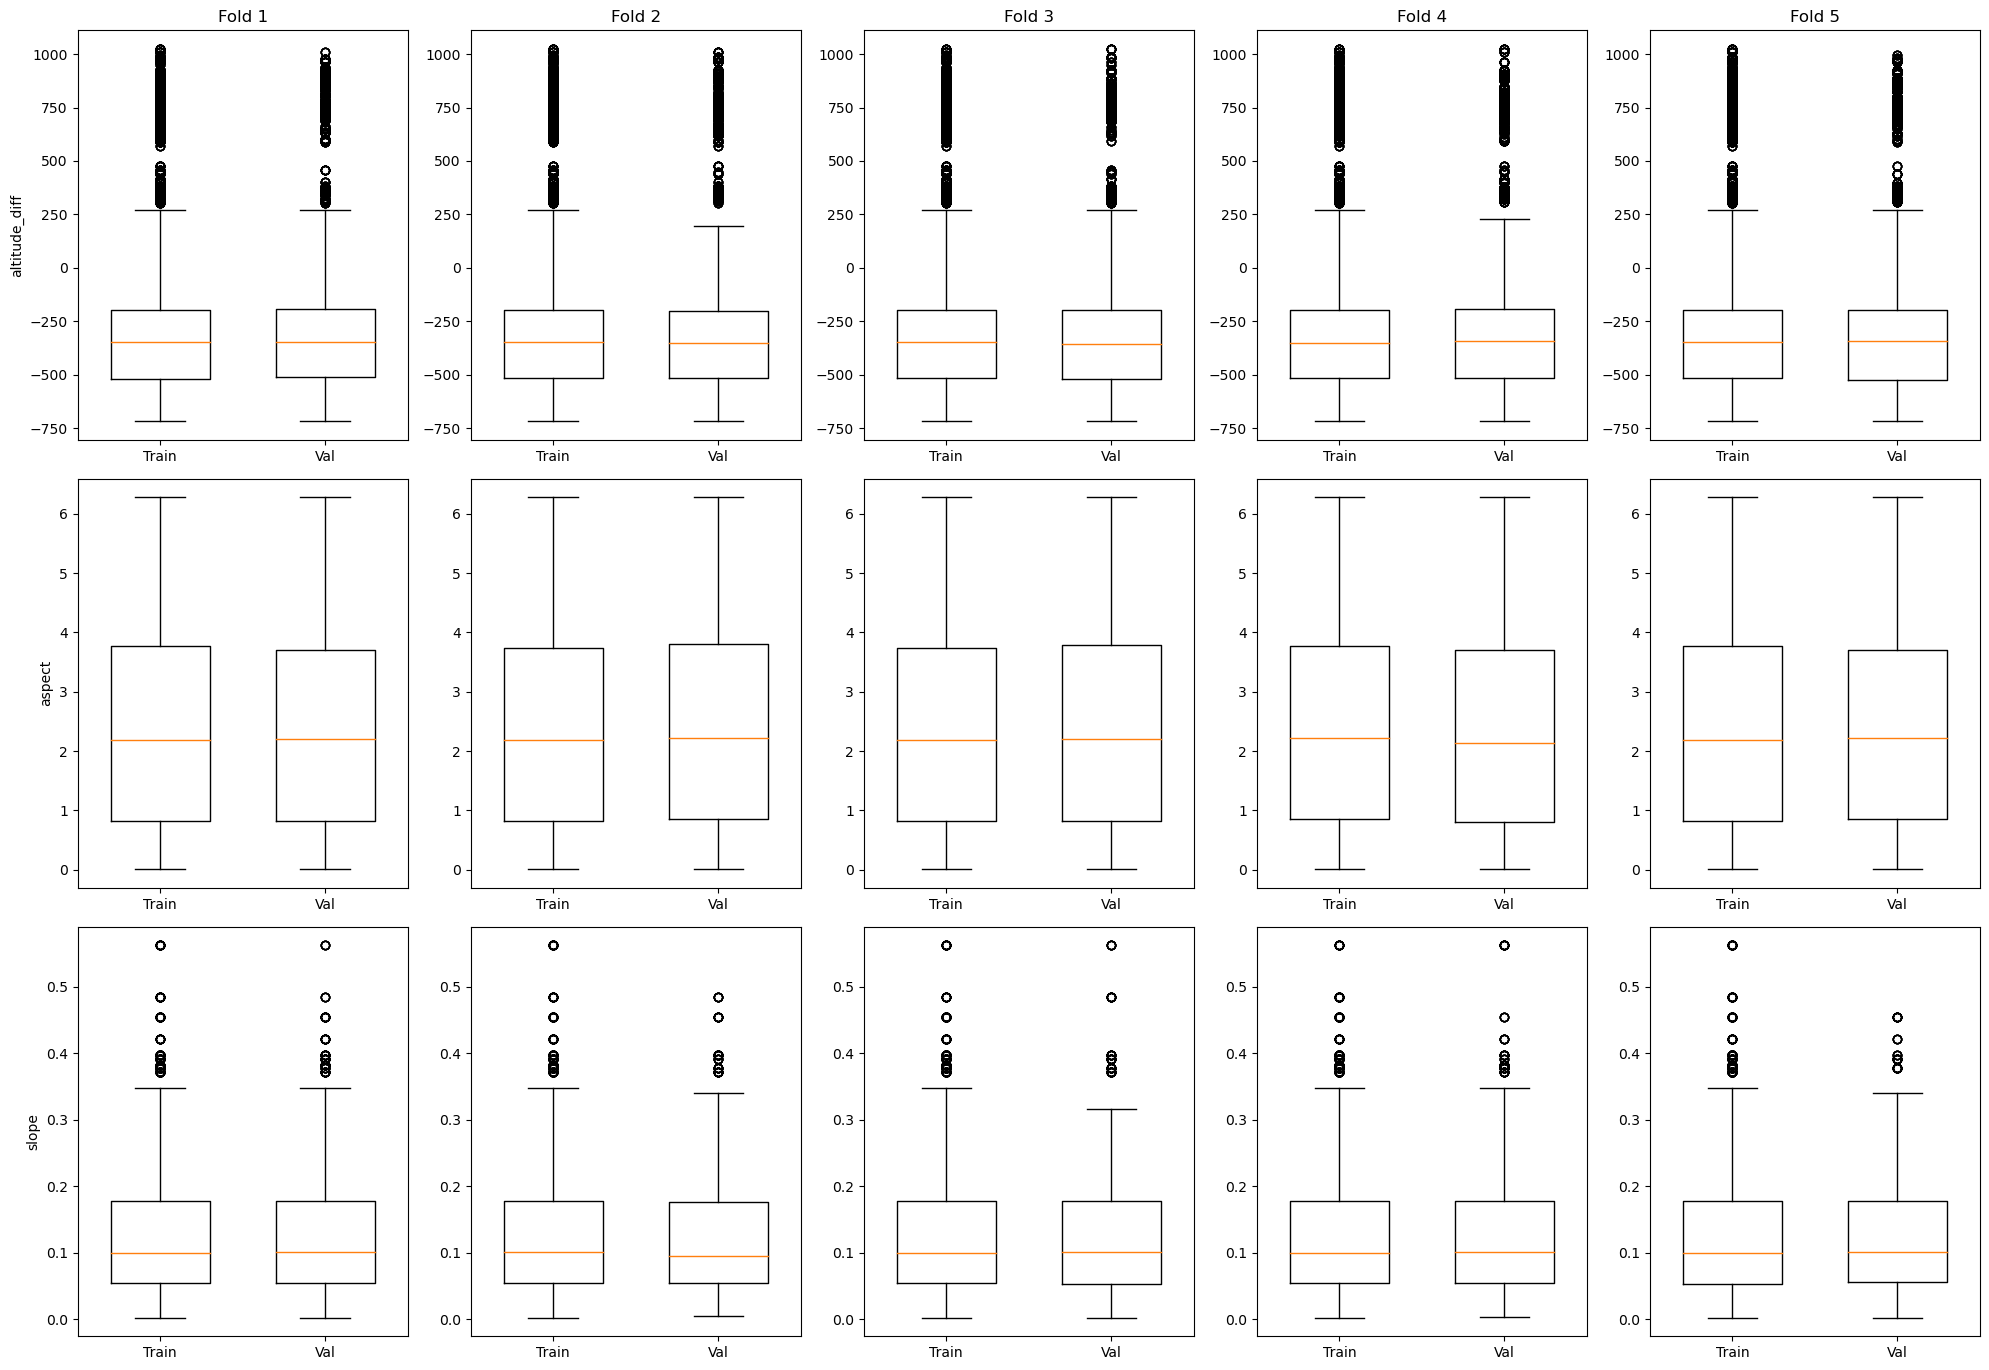

In [11]:
# Visualization of features
# Index(['altitude_diff', 'aspect', 'slope', 't2m', 'sshf', 'slhf', 'ssrd',
#       'fal', 'str', 'tp', 'id', 'n_months', 'month'],

feature_names = ['altitude_diff', 'aspect', 'slope']

fig, axes = plt.subplots(len(feature_names), 5, figsize=(20, len(feature_names) * 5))

for row, feature in enumerate(feature_names):
    for col, (train_index, val_index) in enumerate(splits_s):

        feature_train = df_train_X.iloc[train_index][feature]
        feature_val = df_train_X.iloc[val_index][feature]
        
        feature_data_combined = [feature_train, feature_val]
        
        axes[row, col].boxplot(feature_data_combined, positions=[1, 2], widths=0.6)
        
        if row == 0:
            axes[row, col].set_title(f'Fold {col+1}')
        if col == 0:
            axes[row, col].set_ylabel(feature)
        
        axes[row, col].set_xticks([1, 2])
        axes[row, col].set_xticklabels(['Train', 'Val'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

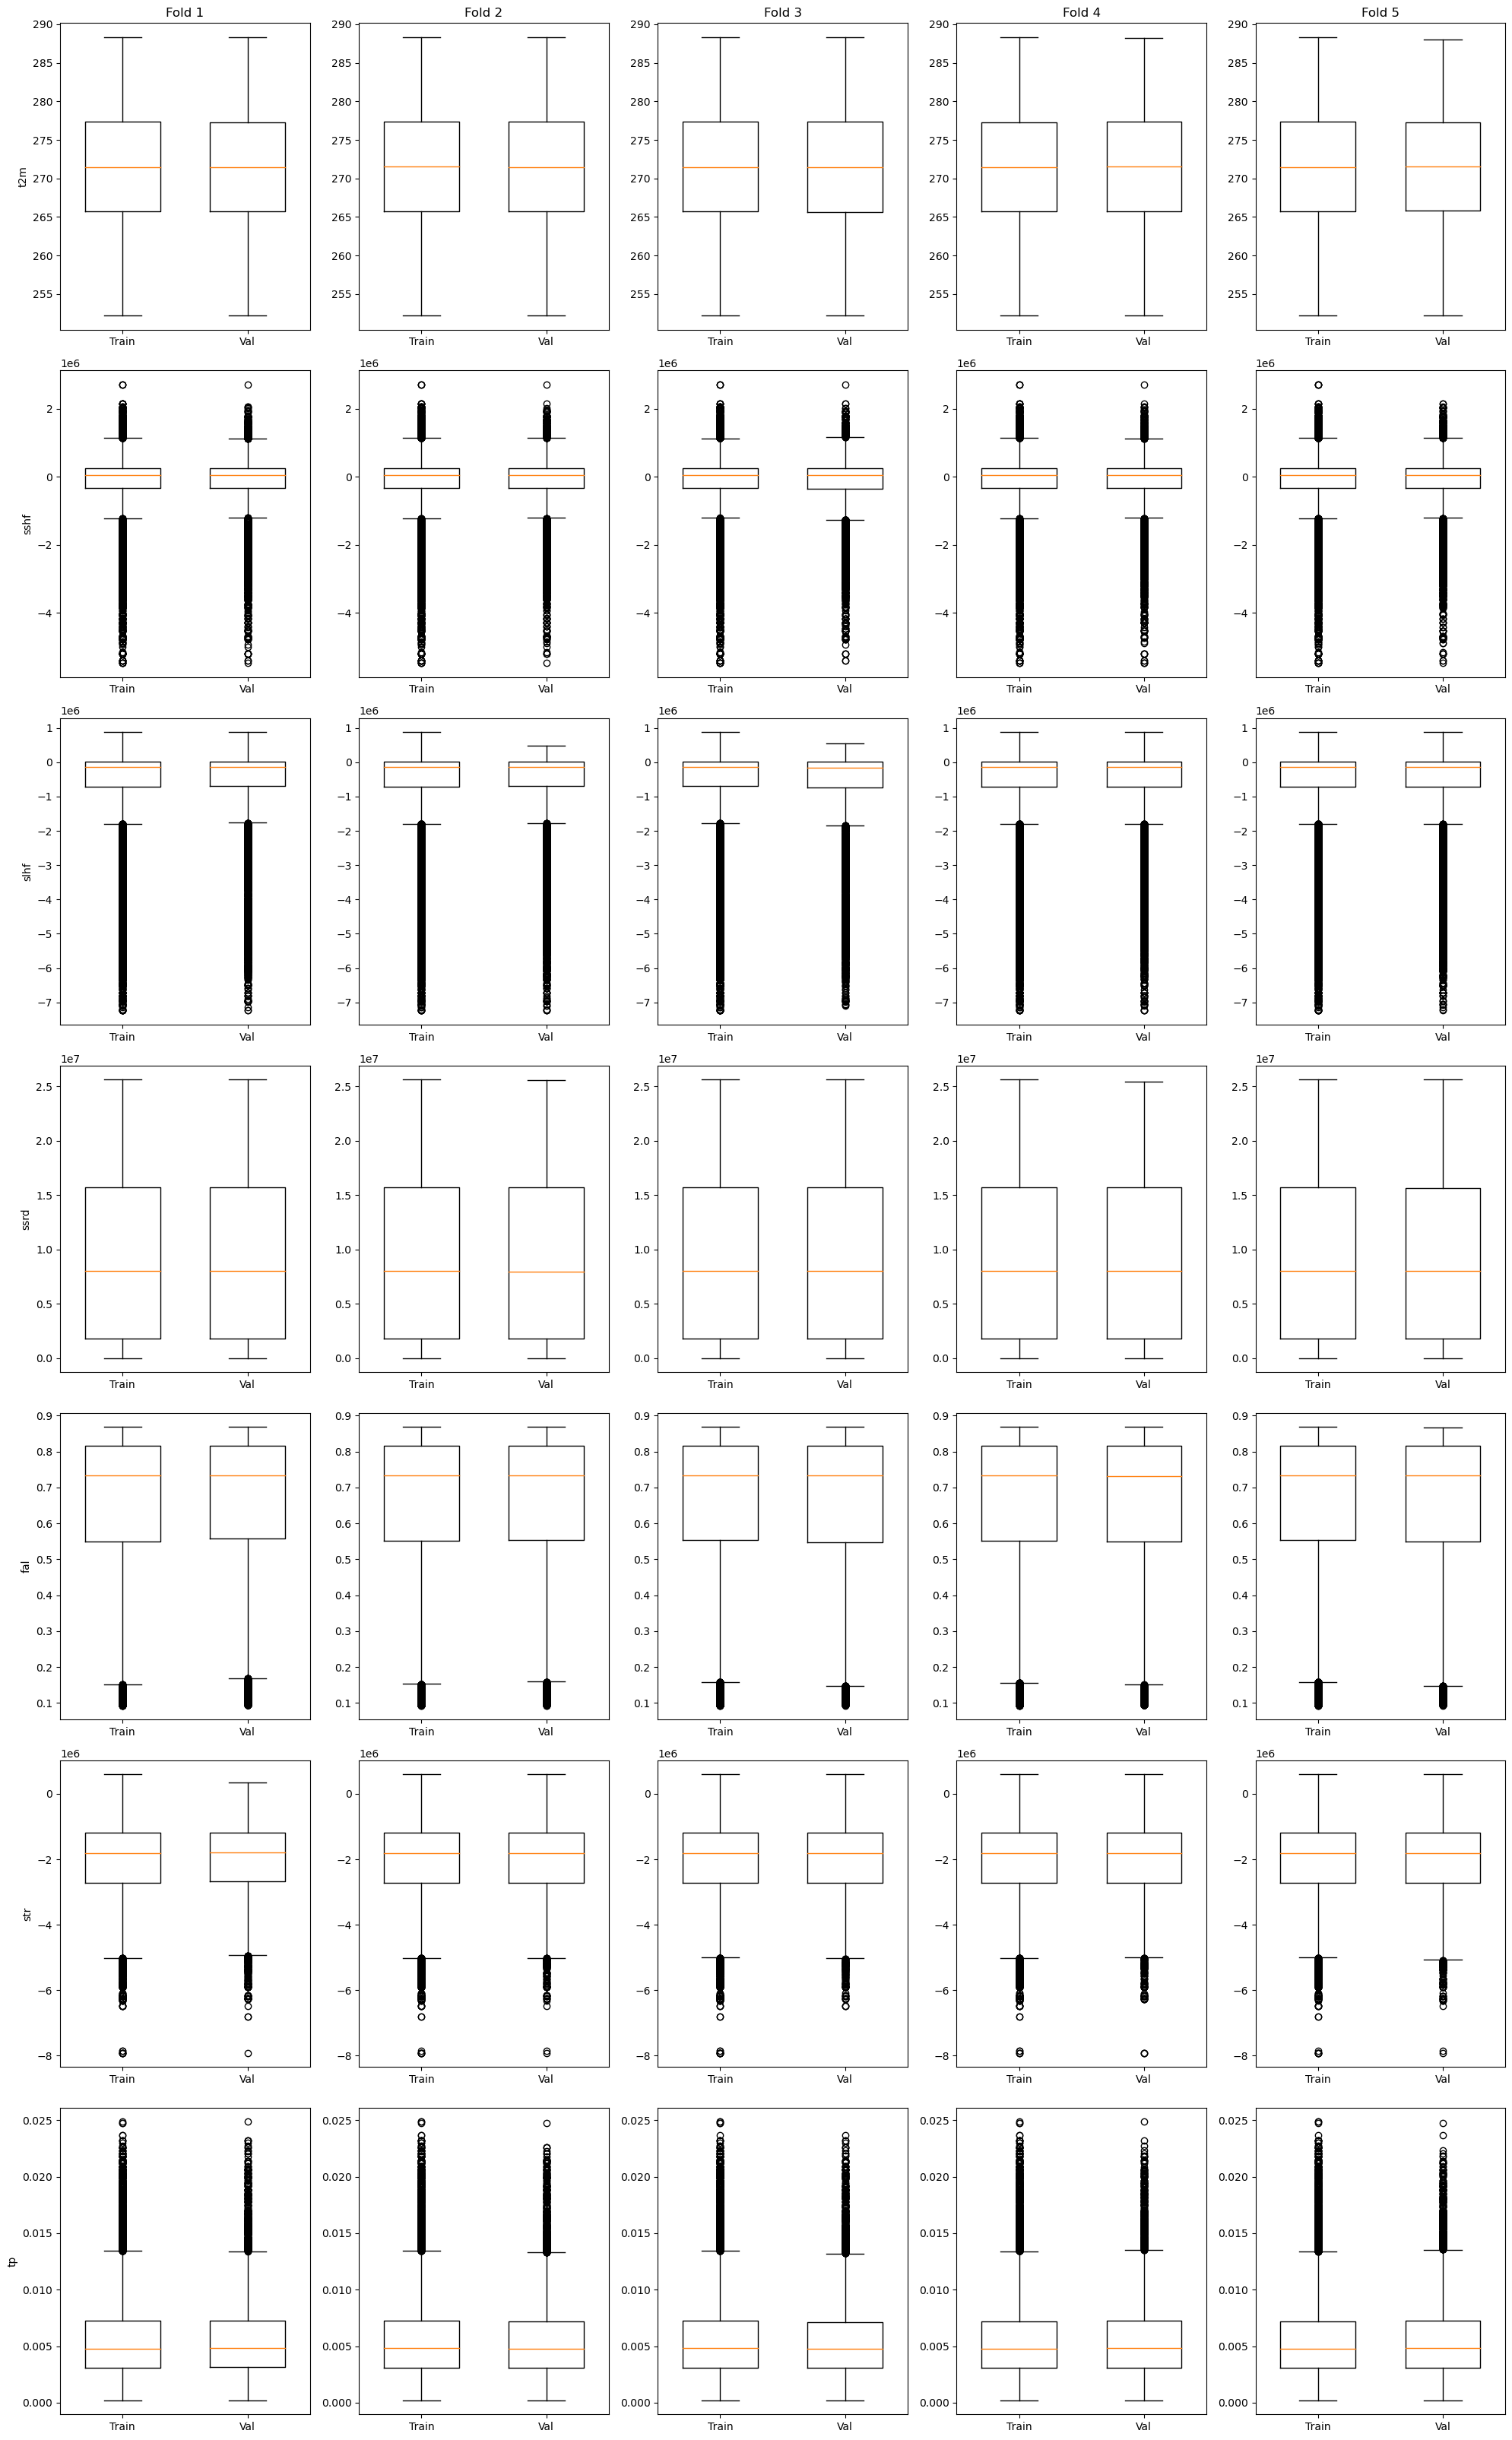

In [41]:
# Visualization of features
# Index(['altitude_diff', 'aspect', 'slope', 't2m', 'sshf', 'slhf', 'ssrd',
#       'fal', 'str', 'tp', 'id', 'n_months', 'month'],

feature_names = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal', 'str', 'tp']

fig, axes = plt.subplots(len(feature_names), 5, figsize=(20, len(feature_names) * 5))

for row, feature in enumerate(feature_names):
    for col, (train_index, val_index) in enumerate(splits_s):

        feature_train = df_train_X.iloc[train_index][feature]
        feature_val = df_train_X.iloc[val_index][feature]
        
        feature_data_combined = [feature_train, feature_val]
        
        axes[row, col].boxplot(feature_data_combined, positions=[1, 2], widths=0.6)
        
        if row == 0:
            axes[row, col].set_title(f'Fold {col+1}')
        if col == 0:
            axes[row, col].set_ylabel(feature)
        
        axes[row, col].set_xticks([1, 2])
        axes[row, col].set_xticklabels(['Train', 'Val'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 3 Finalize test dataset

In [12]:
# Select features for test
df_test_X_reduce = df_test_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_test_X = df_test_X_reduce[[c for c in df_test_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for test
df_test_y = df_test_final[['balance']]

# Get arrays of features+metadata and targets
X_test, y_test = df_test_X.values, df_test_y.values

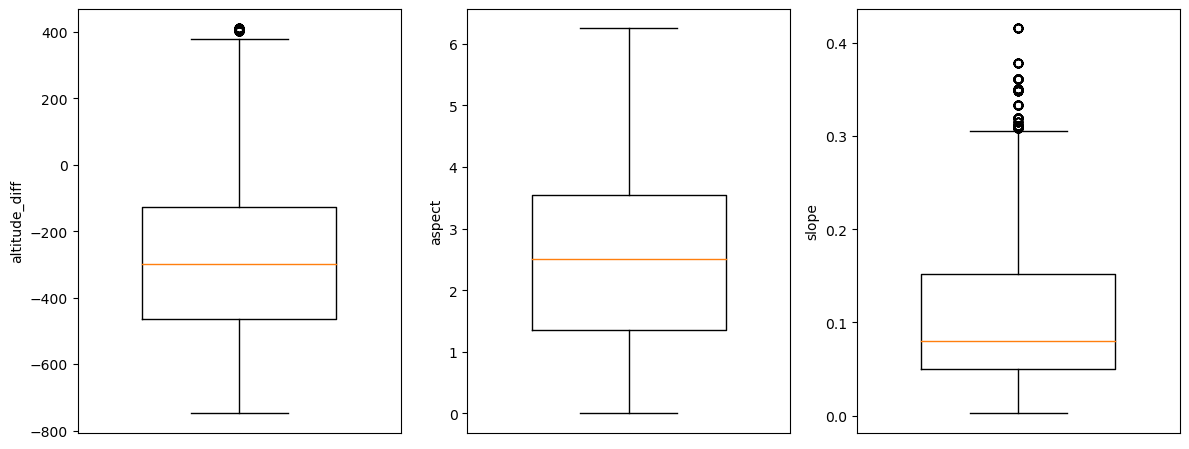

In [13]:
# Visualize test distributions

feature_names = ['altitude_diff', 'aspect', 'slope']

fig, axes = plt.subplots(1, len(feature_names), figsize=(12, 5))

for col, feature in enumerate(feature_names):
    feature_test = df_test_X[feature]  
    axes[col].boxplot(feature_test, positions=[1], widths=0.6)  

    axes[col].set_ylabel(feature)  

    axes[col].set_xticks([])

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

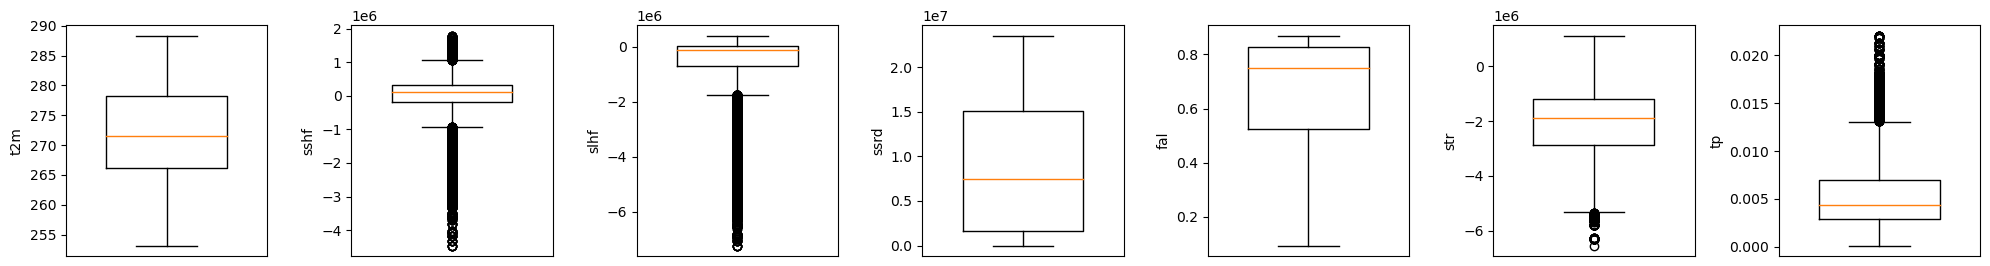

In [14]:
# Visualize test distributions

feature_names = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal', 'str', 'tp']

fig, axes = plt.subplots(1, len(feature_names), figsize=(20, 3))

for col, feature in enumerate(feature_names):
    feature_test = df_test_X[feature]  
    axes[col].boxplot(feature_test, positions=[1], widths=0.6)  

    axes[col].set_ylabel(feature)  

    axes[col].set_xticks([])

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

## 4 Define loss function and helper functions

#### Custom loss/objective function scikit learn api with metadata

To be used with custom XGBRegressor class

In [15]:
# Custom objective function scikit learn api with metadata, to be used with custom XGBRegressor class

def custom_mse_metadata(y_true, y_pred, metadata):
    """
    Custom Mean Squared Error (MSE) objective function for evaluating monthly predictions with respect to 
    seasonally or annually aggregated observations.
    
    For use in cases where predictions are done on a monthly time scale and need to be aggregated to be
    compared with the true aggregated seasonal or annual value. Aggregations are performed according to a
    unique ID provided by metadata. The function computes gradients and hessians 
    used in gradient boosting methods, specifically for use with the XGBoost library's custom objective 
    capabilities.
    
    Parameters
    ----------
    y_true : numpy.ndarray
        True (seasonally or annually aggregated) values for each instance. For a unique ID, 
        values are repeated n_months times across the group, e.g. the annual mass balance for a group
        of 12 monthly predictions with the same unique ID is repeated 12 times. Before calculating the 
        loss, the mean over the n unique IDs is taken.
    
    y_pred : numpy.ndarray
        Predicted monthly values. These predictions will be aggregated according to the 
        unique ID before calculating the loss, e.g. 12 monthly predictions with the same unique ID is
        aggregated for evaluation against the true annual value.
    
    metadata : numpy.ndarray
        An ND numpy array containing metadata for each monthly prediction. The first column is mandatory 
        and represents the ID of the aggregated group to which each instance belongs. Each group identified 
        by a unique ID will be aggregated together for the loss calculation. The following columns in the 
        metadata can include additional information for each instance that may be useful for tracking or further 
        processing but are not used in the loss calculation, e.g. number of months to be aggregated or the name 
        of the month.
        
        ID (column 0): An integer that uniquely identifies the group which the instance belongs to.
            
    Returns
    -------
    gradients : numpy.ndarray
        The gradient of the loss with respect to the predictions y_pred. This array has the same shape 
        as y_pred.
    
    hessians : numpy.ndarray
        The second derivative (hessian) of the loss with respect to the predictions y_pred. For MSE loss, 
        the hessian is constant and thus this array is filled with ones, having the same shape as y_pred.
    """
    
    # Initialize empty arrays for gradient and hessian
    gradients = np.zeros_like(y_pred)
    hessians = np.ones_like(y_pred) # Ones in case of mse
    
    # Unique aggregation groups based on the aggregation ID
    unique_ids = np.unique(metadata[:, 0])
    
    # Loop over each unique ID to aggregate accordingly
    for uid in unique_ids:
        # Find indexes for the current aggregation group
        indexes = metadata[:, 0] == uid
        
        # Aggregate y_pred for the current group
        y_pred_agg = np.sum(y_pred[indexes])
        
        # True value is the same repeated value for the group, so we can use the mean
        y_true_mean = np.mean(y_true[indexes])
        
        # Compute gradients for the group based on the aggregated prediction
        gradient = y_pred_agg - y_true_mean
        gradients[indexes] = gradient

    return gradients, hessians

#### Custom estimator class based on XGBRegressor

Inherits from xgboost.XGBRegressor 

Note/to-do: Modify def __init__(self,..) to retrieve kwarg for number of columns of metadata (n_metadata) with default n_metadata=None, to allow for flexibility in the number of metadata columns.

In [16]:
from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted

class CustomXGBRegressor(XGBRegressor):
    """
    CustomXGBRegressor is an extension of the XGBoost regressor that incorporates additional metadata into the learning process. The estimator
    is tailored to handle training datasets where the last three columns are metadata rather than features.
    
    The metadata is utilized in a custom mean squared error function. This function calculates gradients and hessians incorporating metadata, 
    allowing the model to learn from both standard feature data and additional information provided as metadata.
    
    The custom objective closure captures metadata along with the target values and predicted values to compute the gradients and hessians needed
    for the XGBoost training process.
    
    Parameters inherited from XGBRegressor are customizable and additional parameters can be passed via kwargs, which will be handled by the
    XGBRegressor's __init__ method.
    
    Examples
    --------
    >>> model = CustomXGBRegressor(n_estimators=500, learning_rate=0.05)
    >>> model.fit(X_train, y_train)  # X_train includes metadata as the last 3 columns
    >>> predictions = model.predict(X_test)  # X_test includes metadata as the last 3 columns
    
    Note: CustomXGBRegressor requires a custom MSE function, `custom_mse_metadata`, which computes the gradient and hessian using additional metadata.
    """
    
    def __init__(self, metadata_shape=3, **kwargs):
        self.metadata_shape = metadata_shape
        super().__init__(**kwargs)

    def fit(self, X, y, **fit_params):
        # Split features from metadata
        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]

        # Define closure that captures metadata for use in custom objective
        def custom_objective(y_true, y_pred):
            return custom_mse_metadata(y_true, y_pred, metadata)

        # Set custom objective
        self.set_params(objective=custom_objective)

        # Call fit method from parent class (XGBRegressor)
        super().fit(features, y, **fit_params)

        return self

    def predict(self, X):
        # Check if the model is fitted
        check_is_fitted(self)
        
        features = X[:, :-self.metadata_shape]
        
        return super().predict(features)



#### Custom scoring function to be used with Scikit learn grid search cv

To use sklearn GridSearchCV we need a custom scoring function to evaluate the mse of predictions from each trained model on the validation fold. 
Currently, preds are monthly and y_val are dummy/repeated seasonal observations, i.e. the custom scorer needs to aggregate preds from the trained model to seasonal resolution and get mean of y_val for each identifier.

https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object

To-do:
Using custom scorers in functions where n_jobs > 1

While defining the custom scoring function alongside the calling function should work out of the box with the default joblib backend (loky), importing it from another module will be a more robust approach and work independently of the joblib backend.

For example, to use n_jobs greater than 1 in the example below, custom_scoring_function function is saved in a user-created module (custom_scorer_module.py) and imported:

from custom_scorer_module import custom_scoring_fun
ction 
cross_val_score(model,
 X_train,
 y_train,
 scoring=make_scorer(custom_scoring_function, greater_is_better=False),
 cv=5,
 n_jobs=-1) 


In [54]:
# Need to use the make_scorer function to turn the 
# custom evaluation function into a scorer object
from sklearn.metrics import make_scorer

def custom_mse_scorer(y_true, y_pred, X):
    # Extract metadata
    metadata = X[:, -3:] 


    all_pred_agg = []
    all_true_mean = []
    
    unique_ids = np.unique(metadata[:, 0]) # ID is first column of metadata
    
    # Loop over each unique ID to aggregate/get mean
    for uid in unique_ids:

        indexes = metadata[:, 0] == uid
        
        # Aggregate predictions for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        
        # Get mean of true values for the current ID
        y_true_mean = np.mean(y_true[indexes])

        all_pred_agg.append(y_pred_agg)
        all_true_mean.append(y_true_mean)
        
        #mse += (y_pred_agg - y_true_mean) ** 2

    all_pred_agg = np.array(all_pred_agg)
    all_true_mean = np.array(all_true_mean)

    # Compute mse 
    mse = ((all_pred_agg - all_true_mean) ** 2).mean()
    #mse /= len(unique_ids)    
    
    return -mse  # Return negative because GridSearchCV maximizes score

# Wrap custom mse scorer to pass metadata 
def make_custom_mse_scorer():
    """Generates a customized scorer callable as required by GridSearchCV"""
    return make_scorer(custom_mse_scorer, greater_is_better=False, needs_proba=False, needs_X=True)

custom_mse_scorer = make_custom_mse_scorer()

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


#### Helper functions

In [25]:
# Get true values (means) and predicted values (aggregates)

def get_ytrue_y_pred_agg(y_true, y_pred, X):
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

## 5 Model training

### 5.0 Test custom_mse_scorer with GridSearchCV on smaller version of dataset

In [27]:
# Set up dataset with random sample from annual, winter, summer

# Get random sample of annual, summer, winter
df_train_annual_sample = df_train_annual_clean.sample(n=100, random_state=42)
df_train_summer_sample = df_train_summer_clean.sample(n=100, random_state=42)
df_train_winter_sample = df_train_winter_clean.sample(n=100, random_state=42)

# Reshape dataframes to monthly resolution
df_train_summer_sample_final = reshape_dataset_monthly(df_train_summer_sample, id_vars, variables, summer_months_order)
df_train_winter_sample_final = reshape_dataset_monthly(df_train_winter_sample, id_vars, variables, winter_months_order)
df_train_annual_sample_final = reshape_dataset_monthly(df_train_annual_sample, id_vars, variables, annual_months_order)

# Combine training data in one dataframe
df_train_summer_sample_final.reset_index(drop=True, inplace=True)
df_train_winter_sample_final.reset_index(drop=True, inplace=True)
df_train_annual_sample_final.reset_index(drop=True, inplace=True)

data_list = [df_train_summer_sample_final, df_train_winter_sample_final, df_train_annual_sample_final]
df_train_sample_final = pd.concat(data_list)
df_train_sample_final


,id,BREID,year,altitude_diff,balance,aspect,slope,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,141,675,1965,-227.754309,-1.66,3.078870,0.106222,5,may,268.914459,-4.181212e+05,-695383.00,19851934.0,0.772005,-3242743.25,0.002794
1,141,675,1965,-227.754309,-1.66,3.078870,0.106222,5,jun,274.387115,-9.021975e+04,-381101.00,20123284.0,0.613598,-2495870.75,0.002436
2,141,675,1965,-227.754309,-1.66,3.078870,0.106222,5,jul,274.903320,-5.459694e+04,-144687.50,17226452.0,0.656685,-1355156.25,0.003612
3,141,675,1965,-227.754309,-1.66,3.078870,0.106222,5,aug,277.013733,-2.794928e+05,-680575.00,11225525.0,0.462027,-1692081.75,0.002770
4,141,675,1965,-227.754309,-1.66,3.078870,0.106222,5,sep,276.335815,-3.485924e+05,-889926.00,6474673.5,0.316449,-2097636.50,0.002834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,8452,3128,2010,-569.166788,-1.26,5.305048,0.080320,12,may,275.246460,-1.106114e+06,-594537.00,20802266.0,0.561771,-4008649.00,0.002509
1196,8452,3128,2010,-569.166788,-1.26,5.305048,0.080320,12,jun,280.580170,-1.844750e+06,-2827698.75,20615688.0,0.325100,-3886763.00,0.003416
1197,8452,3128,2010,-569.166788,-1.26,5.305048,0.080320,12,jul,283.921143,-2.535318e+06,-5738698.00,15410558.0,0.136575,-3920437.00,0.007220
1198,8452,3128,2010,-569.166788,-1.26,5.305048,0.080320,12,aug,282.866699,-1.961919e+06,-4664881.00,12239132.0,0.128857,-3654886.50,0.006699


In [29]:
# Select features for training
df_train_X_reduce = df_train_sample_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_train_X_sample = df_train_X_reduce[[c for c in df_train_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for training
df_train_y_sample = df_train_sample_final[['balance']]

# Get arrays of features+metadata and targets
X_train_s, y_train_s = df_train_X_sample.values, df_train_y_sample.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s_s = np.array(df_train_sample_final['id'].values)

# Use five folds
group_kf_s = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s_s = list(group_kf_s.split(X_train_s, y_train_s, gp_s_s))

print(len(gp_s_s))
print(y_train_s.shape)
print(X_train_s.shape)
print(df_train_X_sample.columns)
print(df_train_y_sample.columns)

2400
(2400, 1)
(2400, 13)
Index(['altitude_diff', 'aspect', 'slope', 't2m', 'sshf', 'slhf', 'ssrd',
       'fal', 'str', 'tp', 'id', 'n_months', 'month'],
      dtype='object')
Index(['balance'], dtype='object')


In [31]:
# Check fold indices for training/validation data
fold_indices = []

for train_index, val_index in group_kf_s.split(X_train_s, y_train_s, gp_s_s):
    #print("TRAIN:", train_index, "VALIDATION:", val_index)
    print("shape(train):", train_index.shape, "test:", val_index.shape)
    fold_indices.append((train_index, val_index))


shape(train): (1920,) test: (480,)
shape(train): (1920,) test: (480,)
shape(train): (1920,) test: (480,)
shape(train): (1920,) test: (480,)
shape(train): (1920,) test: (480,)


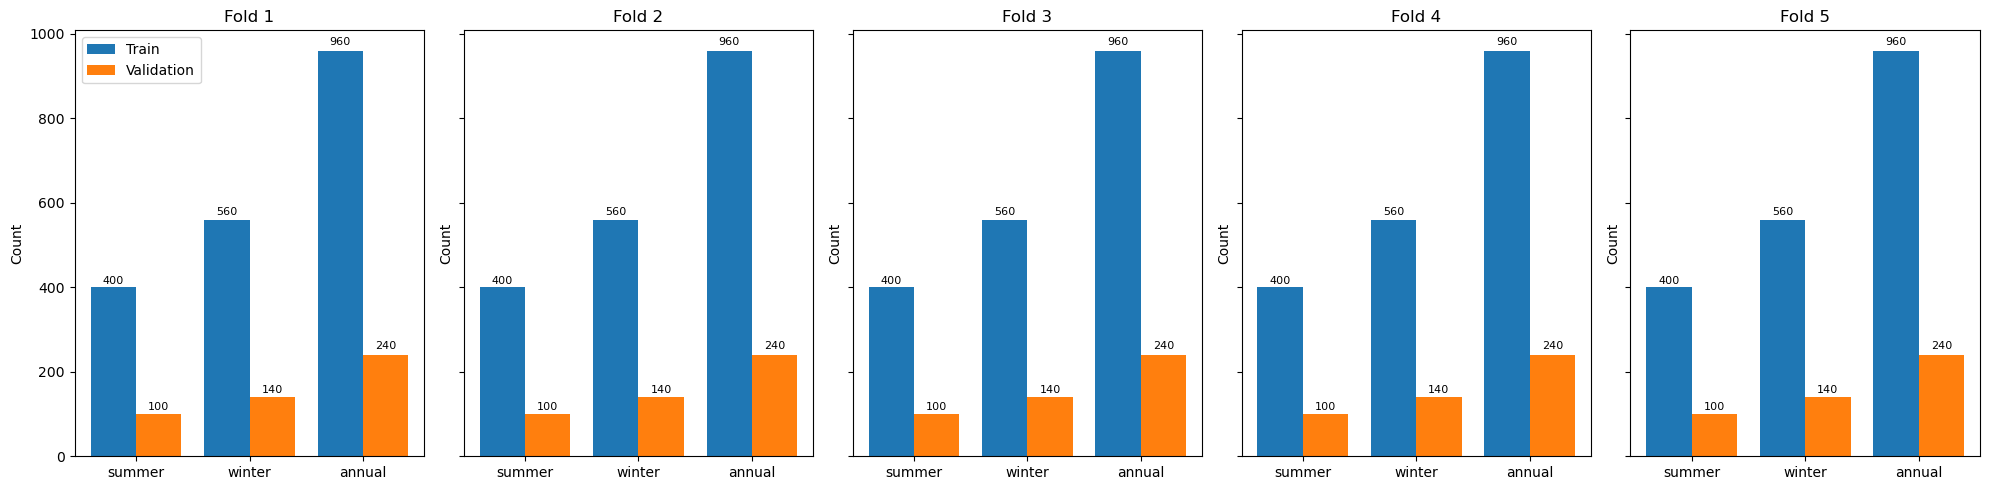

In [32]:
# Count number of annual and seasonal per fold

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

# Create a color map or list for the bars
colors = ['C0', 'C1']

n_months_to_season = {5: 'summer', 7: 'winter', 12: 'annual'}

for i, (train_index, val_index) in enumerate(splits_s_s):
    ax = axes[i]

    n_months_train = df_train_X_sample.iloc[train_index]['n_months']
    n_months_val = df_train_X_sample.iloc[val_index]['n_months']
    
    # Counts
    n_months_train_counts = dict(zip(*np.unique(n_months_train, return_counts=True)))
    n_months_val_counts = dict(zip(*np.unique(n_months_val, return_counts=True)))
    
    #n_months_values = sorted(set(n_months_train_counts.keys()).union(n_months_val_counts.keys()))
    n_months_values = sorted(set(n_months_train_counts.keys()).union(n_months_val_counts.keys()))
    season_names = [n_months_to_season[n_months] for n_months in n_months_values]

    train_positions = np.arange(len(n_months_values))
    val_positions = train_positions + 0.4 
    
    train_counts = [n_months_train_counts.get(x, 0) for x in n_months_values]
    ax.bar(train_positions, train_counts, width=0.4, label='Train', color=colors[0])
    
    val_counts = [n_months_val_counts.get(x, 0) for x in n_months_values]
    ax.bar(val_positions, val_counts, width=0.4, label='Validation', color=colors[1])

    # Annotate each bar with the respective count
    for j in range(len(n_months_values)):
        train_count = n_months_train_counts.get(n_months_values[j], 0)
        val_count = n_months_val_counts.get(n_months_values[j], 0)
        train_pos = train_positions[j]
        val_pos = val_positions[j]
        
        ax.text(train_pos, train_count + max(train_count, val_count) * 0.01, str(train_count),
                ha='center', va='bottom', fontsize=8, color='k')

        ax.text(val_pos, val_count + max(train_count, val_count) * 0.01, str(val_count),
                ha='center', va='bottom', fontsize=8, color='k')
    
    ax.set_title(f'Fold {i+1}')
    #ax.set_xlabel('n_months')
    ax.set_ylabel('Count')
    ax.set_xticks(train_positions + 0.2) 
    #ax.set_xticklabels(n_months_values)  
    ax.set_xticklabels(season_names)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

In [55]:
from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted

class CustomXGBRegressorScorer(XGBRegressor):
    """
    CustomXGBRegressor is an extension of the XGBoost regressor that incorporates additional metadata into the learning process. The estimator
    is tailored to handle training datasets where the last three columns are metadata rather than features.
    
    The metadata is utilized in a custom mean squared error function. This function calculates gradients and hessians incorporating metadata, 
    allowing the model to learn from both standard feature data and additional information provided as metadata.
    
    The custom objective closure captures metadata along with the target values and predicted values to compute the gradients and hessians needed
    for the XGBoost training process.
    
    Parameters inherited from XGBRegressor are customizable and additional parameters can be passed via kwargs, which will be handled by the
    XGBRegressor's __init__ method.
    
    Examples
    --------
    >>> model = CustomXGBRegressor(n_estimators=500, learning_rate=0.05)
    >>> model.fit(X_train, y_train)  # X_train includes metadata as the last 3 columns
    >>> predictions = model.predict(X_test)  # X_test includes metadata as the last 3 columns
    
    Note: CustomXGBRegressor requires a custom MSE function, `custom_mse_metadata`, which computes the gradient and hessian using additional metadata.
    """
    
    def __init__(self, metadata_shape=3, **kwargs):
        self.metadata_shape = metadata_shape
        super().__init__(**kwargs)

    def fit(self, X, y, **fit_params):
        # Split features from metadata
        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]

        # Define closure that captures metadata for use in custom objective
        def custom_objective(y_true, y_pred):
            return custom_mse_metadata(y_true, y_pred, metadata)

        # Set custom objective
        self.set_params(objective=custom_objective)

        # Call fit method from parent class (XGBRegressor)
        super().fit(features, y, **fit_params)

        return self

    def predict(self, X):
        # Check if the model is fitted
        check_is_fitted(self)
        
        features = X[:, :-self.metadata_shape]
        
        return super().predict(features)

    def score(self, X, y, sample_weight=None):

        y_pred = self.predict(X)

        metadata, features = X[:, -self.metadata_shape:], X[:, :-self.metadata_shape]
        
        all_pred_agg = []
        all_true_mean = []
    
        unique_ids = np.unique(metadata[:, 0]) # ID is first column of metadata

        # Loop over each unique ID to aggregate/get mean
        for uid in unique_ids:

            indexes = metadata[:, 0] == uid
        
            # Aggregate predictions for the current ID
            y_pred_agg = np.sum(y_pred[indexes])
        
            # Get mean of true values for the current ID
            y_true_mean = np.mean(y[indexes])

            all_pred_agg.append(y_pred_agg)
            all_true_mean.append(y_true_mean)
        
            #mse += (y_pred_agg - y_true_mean) ** 2

        all_pred_agg = np.array(all_pred_agg)
        all_true_mean = np.array(all_true_mean)

        # Compute mse 
        mse = ((all_pred_agg - all_true_mean) ** 2).mean()

        return -mse # Return negative because GridSearchCV maximizes score
        
        #return r2_score(y, y_pred, sample_weight=sample_weight)
        


In [56]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 4],#, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1],#, 0.2, 0.3],
    'n_estimators': [500],
    'gamma':[0]#, 1, 10],
    }

xgb_model_s = CustomXGBRegressorScorer()
# When you use this in GridSearchCV, you will capture X at the time you create the scorer:
#custom_mse_scorer = make_custom_mse_scorer(X_train_s)

clf = GridSearchCV(xgb_model_s, 
                   param_grid, 
                   cv=splits_s_s,
                   verbose=2, 
                   n_jobs=1, 
                   #scoring=custom_mse_scorer, 
                   scoring = None, # Uses default in CustomXGBRegressor()
                   refit=True, 
                   error_score='raise',
                   return_train_score=True) # Default False. If False, cv_results_ will not include training scores.

#X_features = X_train[:,:-3]

clf.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:12:43] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=500; total time=  15.1s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:12:58] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=500; total time=  15.8s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:14] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=500; total time=  15.8s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:30] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=500; total time=  15.5s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:45] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=500; total time=  15.5s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:14:01] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=4, n_estimators=500; total time=  16.7s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:14:18] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=4, n_estimators=500; total time=  16.4s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:14:34] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=4, n_estimators=500; total time=  16.6s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:14:51] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=4, n_estimators=500; total time=  18.3s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:15:10] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=4, n_estimators=500; total time=  19.1s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:15:29] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=500; total time=  18.5s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:15:48] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=500; total time=  18.6s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:16:06] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=500; total time=  18.8s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:16:25] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=500; total time=  18.3s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:16:44] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=500; total time=  18.9s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:17:03] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=4, n_estimators=500; total time=  20.0s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:17:23] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=4, n_estimators=500; total time=  18.9s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:17:42] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=4, n_estimators=500; total time=  18.0s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:18:00] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=4, n_estimators=500; total time=  19.0s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:18:19] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=4, n_estimators=500; total time=  19.3s


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:18:39] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=[(array([   0,    1,    2, ..., 2385, 2386, 2387]),
                  array([  20,   21,   22,   23,   24,   45,   46,   47,   48,   49,   50,
         51,   52,   53,   54,   75,   76,   77,   78,   79,  100,  101,
        102,  103,  104,  155,  156,  157,  158,  159,  175,  176,  177,
        178,  179,  200,  201,  202,  203,  204,  205,  206,  207,  208,
        209,  230,  231,  232,  233,  234,  250,  251,  252,  253,  254,
        270,  271,  272,  273,  274,  295,  296,  297,  298,  299,  320,
        321,  322,  323,  324,  345,  346,  347,  348,  349,  380,  381,
        382...
                                                max_delta_step=None,
                                                max_depth=None, max_leaves=None,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                multi_strategy=None,
                                                n_estimators=None, n_jobs=None,
                                                num_parallel_tree=None,
                                                objective='reg:squarederror', ...),
             n_jobs=1,
             param_grid={'gamma': [0], 'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 4], 'n_estimators': [500]},
             return_train_score=True, verbose=2)

In [57]:
clf.cv_results_

{'mean_fit_time': array([15.63271713, 17.53509316, 18.70572371, 19.1135417 ]),
 'std_fit_time': array([0.24881583, 1.06454934, 0.22265638, 0.63498211]),
 'mean_score_time': array([0.00799742, 0.00898614, 0.00969539, 0.01636415]),
 'std_score_time': array([0.00044181, 0.00677522, 0.00079931, 0.01296193]),
 'param_gamma': masked_array(data=[0, 0, 0, 0],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.1, 0.1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[3, 4, 3, 4],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[500, 500, 500, 500],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 0,
   'learning_rate': 0.01,
   'max_de

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:32:37] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:32:52] WARNING: D:\bld\xgboost-split_1705650032250\work\

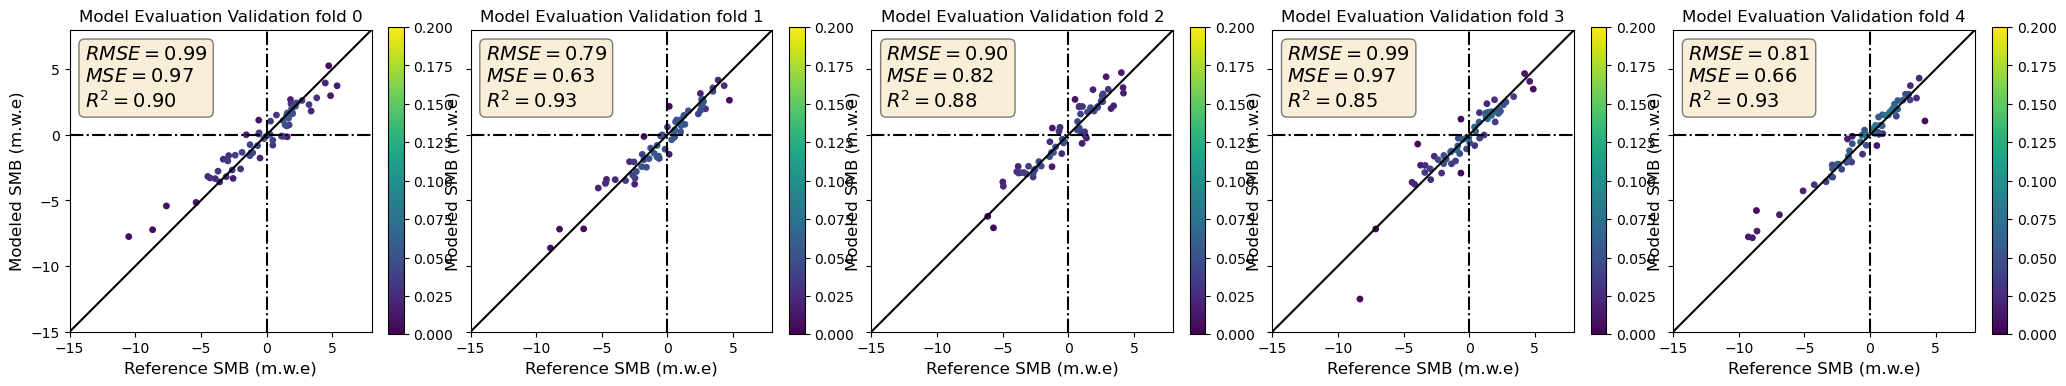

In [61]:
best_model = clf.best_estimator_

# Evaluate validation performance
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, test_index in splits_s_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train_, X_test_ = X_train_s[train_index], X_train_s[test_index]
    y_train_, y_test_ = y_train_s[train_index], y_train_s[test_index]
    best_model.fit(X_train_, y_train_)
    y_pred = best_model.predict(X_test_)

    title = 'Validation fold ' + str(a)

    y_test_agg, y_pred_agg = get_ytrue_y_pred_agg(y_test_,y_pred,X_test_)

    plot_prediction_subplot(y_test_agg, y_pred_agg, title, ax[a], n_toplot=5000, fold=True)

    a=a+1


In [65]:
print(y_test_agg)
print(y_pred_agg)
print(y_test_agg.shape)
print(y_pred_agg.shape)

[-1.66  -1.57  -2.85  -2.39  -4.25  -3.35  -2.95  -2.16  -8.61  -8.65
 -1.72  -0.72  -1.4   -1.61  -2.88  -2.4   -0.57  -5.1   -2.48  -1.79
  1.4    1.86   3.54   2.5    2.94   3.07   3.74   2.7    0.52   0.37
  0.94   1.72   3.05  -0.32   2.     1.84   1.19   0.93   2.1    1.529
 -0.42  -1.35  -6.9    0.21  -2.86  -0.62   0.97   0.69   0.42  -9.27
 -8.96   4.18  -0.32   2.12   1.35   0.62   0.65  -0.28   0.77  -1.35 ]
[-1.642344   -1.2131315  -3.2255888  -2.2846115  -3.8041635  -3.5796897
 -3.1916938  -2.6292212  -7.338102   -5.7696133  -0.31655836 -0.54063755
 -2.081298   -1.8001579  -2.2938132  -2.2418935  -1.4756894  -4.2706046
 -2.237477   -2.1002197   1.5095209   2.3337405   2.8010423   2.6334958
  3.0902085   3.7461863   4.312076    3.0906749  -0.822224    0.11106764
  1.5231515   1.9867405   2.6541865   0.02822254  1.4187634   1.7707916
  1.4729174   0.6874206   1.9520929   1.7703006   0.3541981  -0.6792243
 -6.0897465   0.47165614 -2.5879707  -0.03713137  0.08515656  0.0322180

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:01:11] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


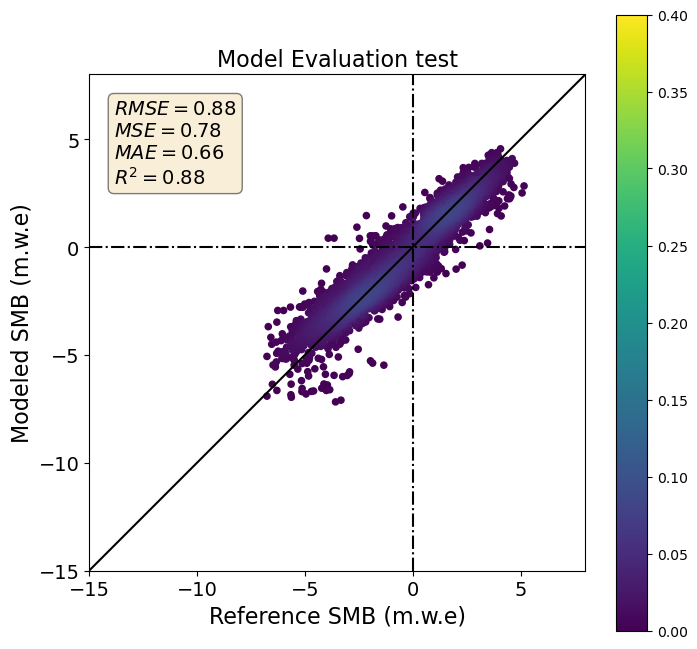

In [49]:
best_model = clf.best_estimator_
best_model.fit(X_train_s, y_train_s)
y_pred_test = best_model.predict(X_test)
#plot_prediction(y_test, y_pred_test, data_type='Test')
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,y_pred_test,X_test)
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

### 5.1 Model testing: Train model on one fold of full dataset 

In [19]:
# Select fold 0 as training data and fold 1 as validation data
#X_train_crop = X_train[fold_indices[0][0],:]
#X_val_crop = X_train[fold_indices[0][1],:]
#y_train_crop = y_train[fold_indices[0][0]]
#y_val_crop = y_train[fold_indices[0][1]]
X_train_crop = X_train[fold_indices[1][0],:]
X_val_crop = X_train[fold_indices[1][1],:]
y_train_crop = y_train[fold_indices[1][0]]
y_val_crop = y_train[fold_indices[1][1]]

# Check folds
print(X_train_crop.shape)
print(X_val_crop.shape)
print(y_train_crop.shape)
print(y_val_crop.shape)

(54329, 13)
(13580, 13)
(54329, 1)
(13580, 1)


In [59]:
# Define custom XGBRegressor object
xgb_model2 = CustomXGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, gamma=0)

# Fit model for fold 0
xgb_model2.fit(X_train_crop, y_train_crop)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:41:58] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=3, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=100, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x00000231C8D245E0>, ...)

In [48]:
# Define custom XGBRegressor object
xgb_model = CustomXGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, gamma=0)

# Fit model for fold 0
xgb_model.fit(X_train_crop, y_train_crop)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [14:09:10] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=3, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=100, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x00000231C9547B50>, ...)

In [67]:
# Save the model to a binary file
xgb_model.save_model('Models/Custom_loss/xgb_model_fold1_test.bin')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:26:32] WARNING: D:\bld\xgboost-split_1705650032250\work\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [78]:
xgb_model2.save_model('Models/Custom_loss/xgb_model_fold2_test.bin')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:29:58] WARNING: D:\bld\xgboost-split_1705650032250\work\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [20]:
# Load model
loaded_model = CustomXGBRegressor()
loaded_model.load_model('Models/Custom_loss/xgb_model_fold1_test.bin')

In [21]:
# Make predictions on the validation data
predictions = loaded_model.predict(X_val_crop)

In [22]:
# Get validation true values and predictions
y_true_mean, y_pred_agg = get_ytrue_y_pred_agg(y_val_crop,predictions,X_val_crop)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


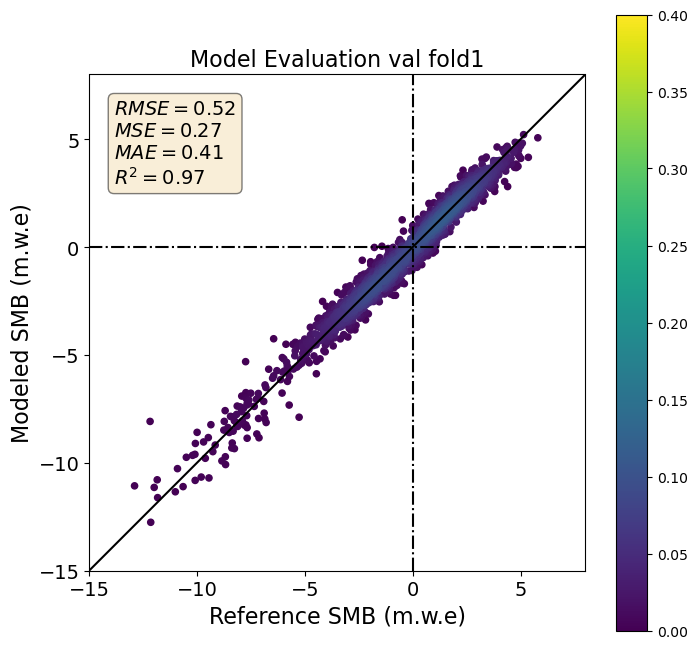

In [23]:
# Plot predictions vs true values for fold 1
plot_prediction(y_true_mean, y_pred_agg, data_type='val fold1')

# 6 Test

In [63]:
# Make predictions on test data
test_pred = xgb_model.predict(X_test)

In [64]:
# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


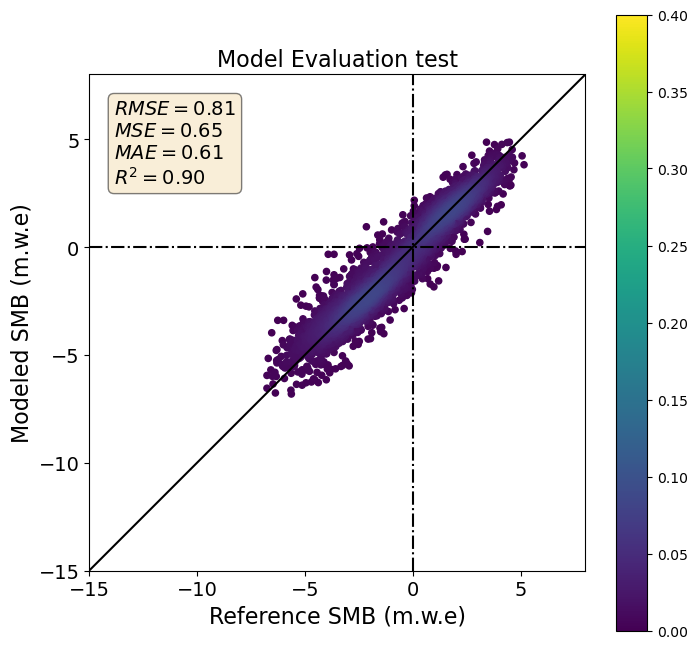

In [65]:
# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

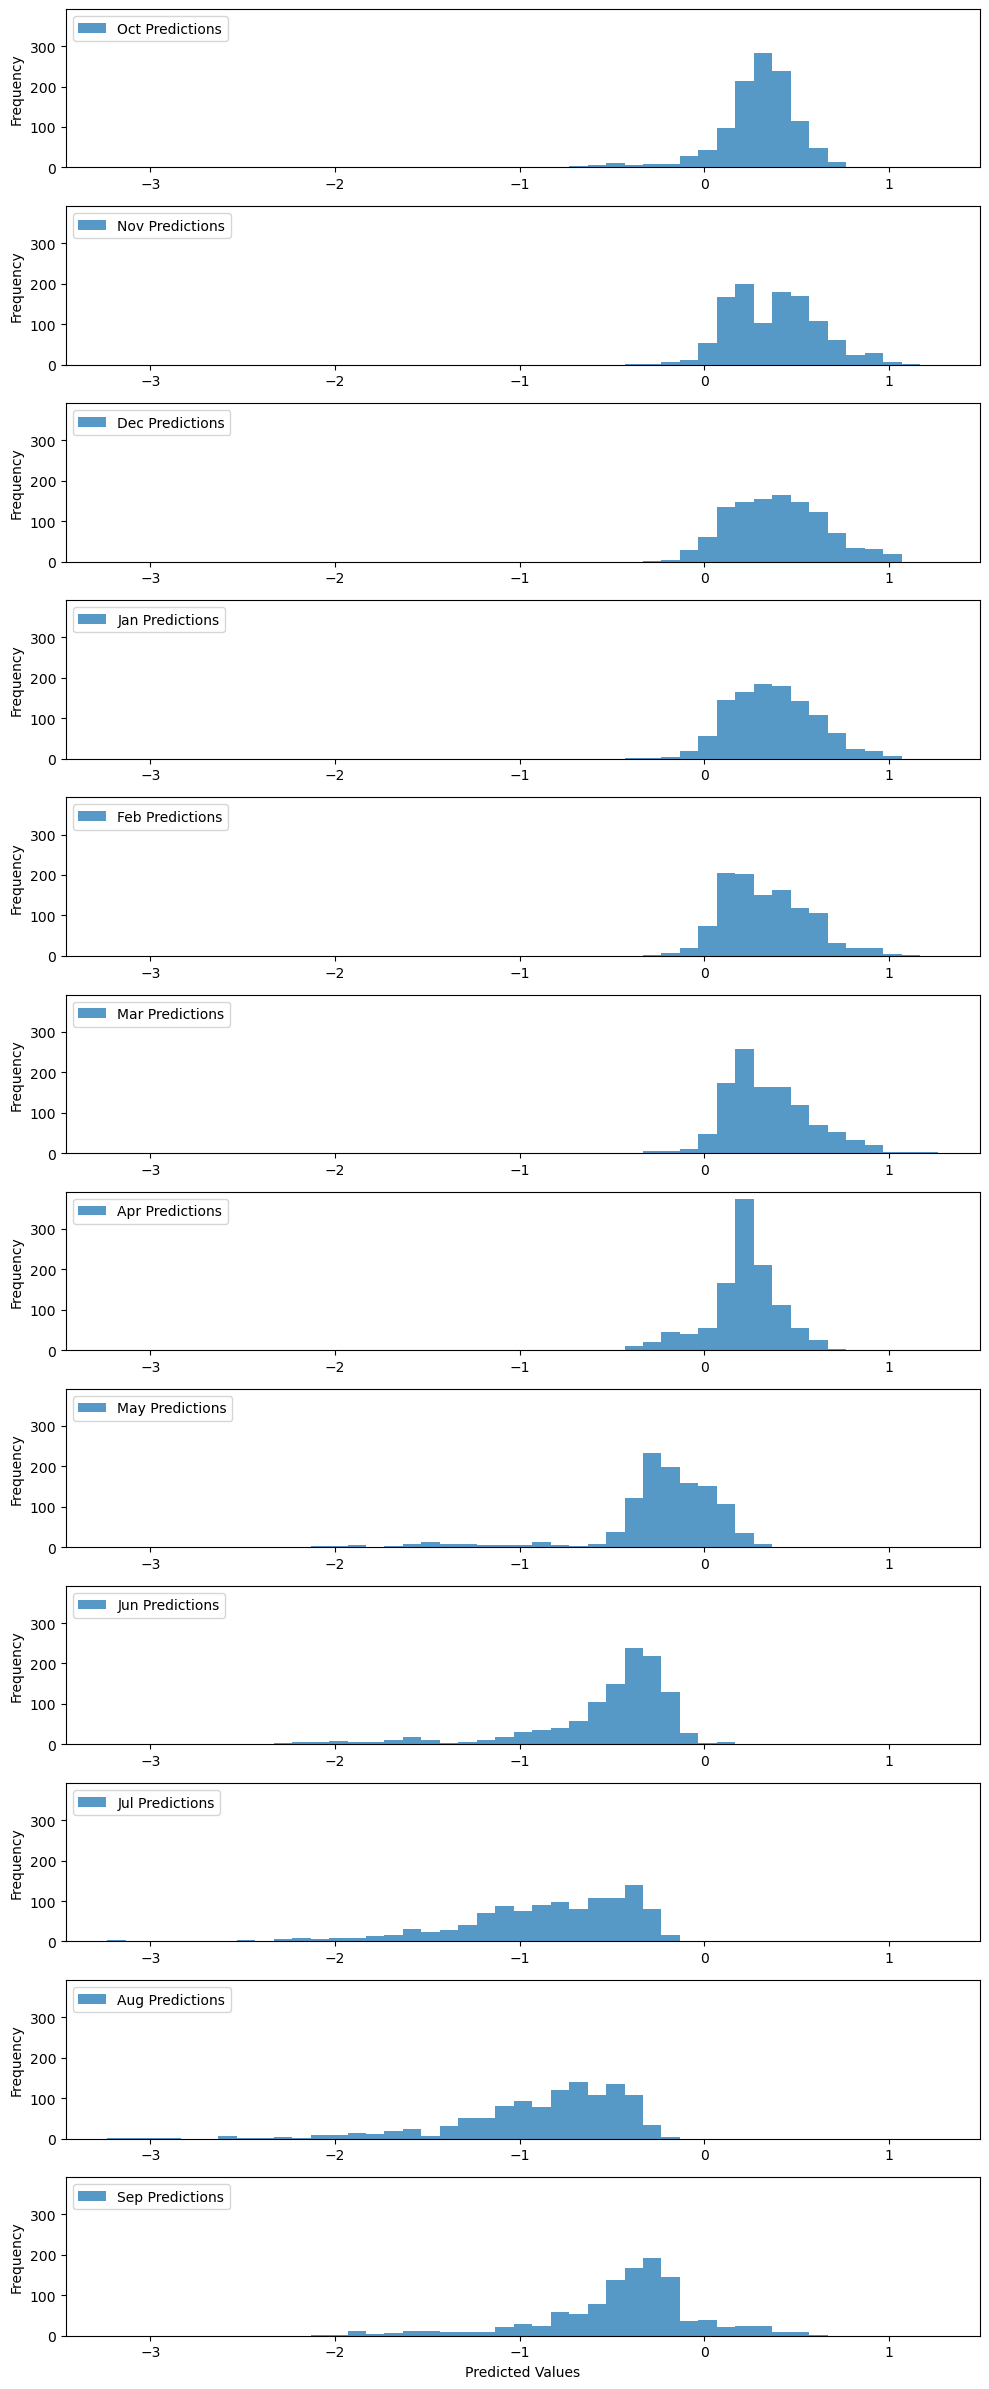

In [56]:
# Plot predicted mass balance distribution for each month

import matplotlib.pyplot as plt

months = X_val_crop[:,-1]

# Define the month order
month_order = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep']

bin_width = 0.1 

min_pred = predictions.min()
max_pred = predictions.max()

# Create bins with the specified width from the global min to max prediction
bins = np.arange(min_pred, max_pred + bin_width, bin_width)

fig, ax = plt.subplots(len(month_order), 1, figsize=(10, 2*len(month_order)), sharex = True, sharey=True)

for i, month in enumerate(month_order):
    month_predictions = predictions[months == month]
    
    ax[i].hist(month_predictions, bins=bins, alpha=0.75, label=f'{month.capitalize()} Predictions')

    ax[i].xaxis.set_tick_params(which='both', labelbottom=True)
    
    #ax[i].set_title(f'{month.capitalize()} distribution')
    ax[i].set_ylabel('Frequency')
    ax[i].legend(loc='upper left')

ax[-1].set_xlabel('Predicted Values')

plt.tight_layout()

plt.show()

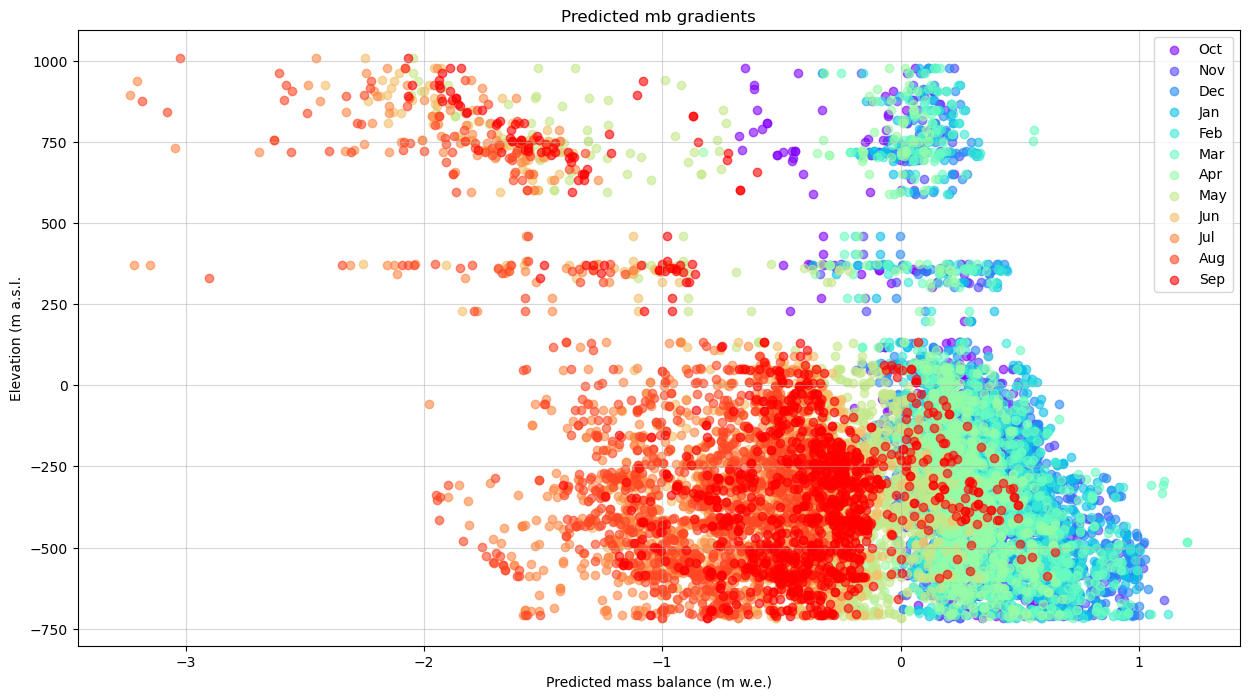

In [57]:
# Plot predicted mass balance gradient for each month

import matplotlib.pyplot as plt

months = X_val_crop[:,-1]
elevation = X_val_crop[:,0]

# Define month order
month_order = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep']
colors = plt.cm.rainbow(np.linspace(0, 1, len(month_order)))

# Map month to color
month_to_color = dict(zip(month_order, colors))

fig, ax = plt.subplots(figsize=(15, 8))

for month in month_order:
    idx = months == month
    ax.scatter(predictions[idx], elevation[idx], label=month.capitalize(), alpha=0.6, c=[month_to_color[month]])

ax.set_xlabel('Predicted mass balance (m w.e.)')
ax.set_ylabel('Elevation (m a.s.l.')
ax.set_title('Predicted mb gradients')
ax.legend()

plt.grid(alpha=0.5)
plt.show()